In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm as cm

%matplotlib inline

In [2]:
bpass_dir = '../data/BPASS/BPASSv2.1_imf135_300/'
logages = np.genfromtxt(bpass_dir+'numbers-bin.z014.dat',unpack=True,usecols=(0))

In [3]:
cols_dict = {'WR':(8,9,10,18,19,20),'RSG':(6,7),'WC':(10,20),'WN':(9,19),'BSG':(1,2,3,4,11,12,13,14),'YSG':(5,15),'O':(1,11)}

In [4]:
zs = ['zem5','zem4','z001','z002','z004','z006','z008','z010','z014','z020','z030','z040']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
f_bins = np.linspace(0,1,11)
i_younger_than_100Myr = np.where(logages <= 8)
ts = logages[i_younger_than_100Myr]

In [24]:
bcmap = cm.get_cmap('plasma')
tcmap = cm.get_cmap('bone')
zcmap = cm.get_cmap('coolwarm')

In [6]:
def z_to_col(z):
    pos_in_arr = np.where(np.array(zs) == z)[0]/len(zs)
    return pos_in_arr[0]

def z_to_val(z):
    pos_in_arr = np.where(np.array(zs) == z)[0][0]
    z_f = z_float[pos_in_arr]
    return z_f

def t_to_col(t):
    pos_in_arr = np.where(np.array(ts) == t)[0]/len(ts)
    return pos_in_arr[0]

In [7]:
def get_arrs(subtype,z):
    """
    Given a subtype of star, gets the appropriate summed arrays from the data tables for both
    single and binary populations
    
    Parameters
    ----------
    subtype : str
        Subtype of star. Currently supports WR, RSG, WC, WN, BSG, YSG, O
    z : str
        Metallicity, in format zXXX. Supports: zem5,zem4,z001,z002,z004,z006,z008,z010,
        z014,z020,z030,z040
    
    Returns
    -------
    b_sum : `~numpy.ndarray`
        Sum of all of the subsubtypes that go into the desired subtype for binaries
    s_sum : `~numpy.ndarray`
        Sum of all of the subsubtypes that go into the desired subtype for singles
    """
    
    b_filename = bpass_dir+'numbers-bin.{0}.dat'.format(z)
    s_filename = bpass_dir+'numbers.{0}.dat'.format(z)
    
    cols = cols_dict[subtype]
    
    b_arrs = np.genfromtxt(b_filename,usecols=cols_dict[subtype],dtype=np.float64)
    b_sum = np.sum(b_arrs,axis=1)
    
    s_arrs = np.genfromtxt(s_filename,usecols=cols_dict[subtype],dtype=np.float64)
    s_sum = np.sum(s_arrs,axis=1)
    
    return b_sum,s_sum

In [8]:
def get_ratio_at_parameter(ratio,z,logtime,f_bin):
    """
    Given a ratio, gets the appropriate summed arrays from the data tables for both
    single and binary populations, interpolates to the binary fraction, and then the 
    time
    
    Parameters
    ----------
    ratio : str
        Name of ratio in the format 'X/Y'. You best hope 'X' and 'Y' are in cols_dict.
    z : str
        Metallicity, in format zXXX. Supports: zem5,zem4,z001,z002,z004,z006,z008,z010,
        z014,z020,z030,z040
    logtime : float
        Log of time in years. Will interpolate.
    f_bin : float
        Binary fraction, must be in range [0,1]
    
    Returns
    -------
    result : float
        The ratio at the given binary fraction, and metallicity, and time
    """
    
    subtypes = ratio.split('/')
    
    subtype1_b,subtype1_s = get_arrs(subtypes[0],z)
    subtype2_b,subtype2_s = get_arrs(subtypes[1],z)
    
    subtype1 = f_bin*subtype1_b + (1-f_bin)*subtype1_s
    subtype2 = f_bin*subtype2_b + (1-f_bin)*subtype2_s
    
    subtype1_t = np.interp(logtime,logages,subtype1,left=0,right=0)
    subtype2_t = np.interp(logtime,logages,subtype2,left=0,right=0)
    
    return np.divide(subtype1_t,subtype2_t)

In [9]:
parname_dict = {'f_bin':f_bins,'z':zs,'logtime':ts}
cmap_dict = {'f_bin':bcmap,'z':zcmap,'logtime':tcmap}
scale_dict = {'WC/WN':'linear','WR/RSG':'log','BSG/RSG':'log','WR/O':'log','WR/YSG':'log'}

In [10]:
def plot_ratios(ratio1,ratio2,par3,par3val):
    """
    Plots ratio1 vs. ratio2, at constant par3 for varying [the other parameters]
    """
    
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    
    if par3 == 'logtime':
        for f in f_bins:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=par3val,z=z_t) for z_t in zs]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=par3val,z=z_t) for z_t in zs]
            ax[0].loglog(r1,r2,c=bcmap(f))
            ax[1].axvline(x=f,c=bcmap(f))
        for z_t in zs:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=par3val,z=z_t) for f in f_bins]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=par3val,z=z_t) for f in f_bins]
            ax[0].loglog(r1,r2,c=zcmap(z_to_col(z_t)))
            ax[1].axhline(y=np.log10(z_to_val(z_t)),c=zcmap(z_to_col(z_t)))
        ax[1].set(xlabel=r'$f_{bin}$',ylabel=r'$\log{Z}$') 
        
    elif par3 == 'f_bin':
        for t in ts:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=par3val,logtime=t,z=z_t) for z_t in zs]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=par3val,logtime=t,z=z_t) for z_t in zs]
            ax[0].loglog(r1,r2,c=tcmap(t_to_col(t)))
            ax[1].axvline(t,c=tcmap(t_to_col(t)))
        for z_t in zs:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=par3val,logtime=t,z=z_t) for t in ts]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=par3val,logtime=t,z=z_t) for t in ts]
            ax[0].loglog(r1,r2,c=zcmap(z_to_col(z_t)))
            ax[1].axhline(y=np.log10(z_to_val(z_t)),c=zcmap(z_to_col(z_t)))  
        ax[1].set(xlabel=r'$\log{t}$',ylabel=r'$\log{Z}$') 
        
    elif par3 == 'z':
        for t in ts:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=t,z=par3val) for f in f_bins]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=t,z=par3val) for f in f_bins]
            ax[0].loglog(r1,r2,c=tcmap(t_to_col(t)))
            ax[1].axvline(t,c=tcmap(t_to_col(t)))
        for f in f_bins:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=t,z=par3val) for t in ts]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=t,z=par3val) for t in ts]
            ax[0].loglog(r1,r2,c=bcmap(f))
            ax[1].axhline(y=f,c=bcmap(f))
        ax[1].set(xlabel=r'$\log{t}$',ylabel=r'$f_{bin}$') 
        
    ax[0].set(xlabel=r'${}$'.format(ratio1),ylabel=r'${}$'.format(ratio2),title=par3+' = {0}'.format(par3val))
    
    return fig,ax

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


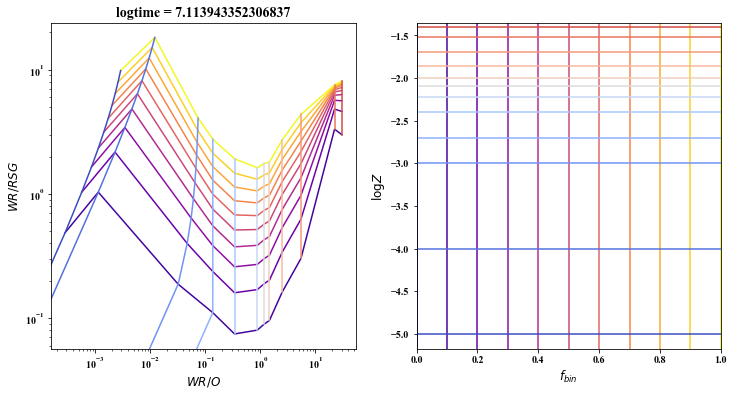

In [25]:
fig, ax = plot_ratios(ratio1='WR/O',ratio2='WR/RSG',par3='logtime',par3val=np.log10(13e6))
#ax[0].set(xlim=(7e-2,1e1),ylim=(7e2,4e4));